Pre-Trained Model : MobileNet

In [1]:
import os
import gc
import cv2
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision.transforms as torchvision_T
from torchvision.models.segmentation import deeplabv3_resnet50
from torchvision.models.segmentation import deeplabv3_mobilenet_v3_large

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [3]:
def order_points(pts):
    # Initialiser un tableau pour stocker les coins ordonnés
    rect = np.zeros((4, 2), dtype="float32")
    # Convertir les points d'entrée en un tableau numpy
    pts = np.array(pts)
    # Calculer la somme des coordonnées x et y de chaque point
    s = pts.sum(axis=1)
    # Trouver les coins supérieur gauche et inférieur droit en utilisant l'indice de somme minimale et maximale
    rect[0] = pts[np.argmin(s)]  # Coin supérieur gauche
    rect[2] = pts[np.argmax(s)]  # Coin inférieur droit

    # Calculer la différence des coordonnées x et y de chaque point
    diff = np.diff(pts, axis=1)
    # Trouver les coins supérieur droit et inférieur gauche en utilisant l'indice de différence minimale et maximale
    rect[1] = pts[np.argmin(diff)]  # Coin supérieur droit
    rect[3] = pts[np.argmax(diff)]  # Coin inférieur gauche
    # Convertir les coordonnées en entiers et les retourner sous forme de liste
    return rect.astype("int").tolist()



def find_dest(pts):
    # Désigner les coins du quadrilatère (coins du rectangle) à partir des points d'entrée
    (tl, tr, br, bl) = pts

    # Calculer les longueurs des côtés du rectangle
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))

    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))

    # Créer les coins de destination cible en fonction des longueurs calculées
    destination_corners = [[0, 0], [maxWidth, 0], [maxWidth, maxHeight], [0, maxHeight]]

    # Ordonner les coins de destination et les retourner
    return order_points(destination_corners)


In [4]:
def image_preproces_transforms(
    mean=(0.4611, 0.4359, 0.3905), std=(0.2193, 0.2150, 0.2109)
):
    common_transforms = torchvision_T.Compose(
        [torchvision_T.ToTensor(), torchvision_T.Normalize(mean, std),]
    )

    return common_transforms


"""La fonction load_model charge un modèle de segmentation d'image
(soit MobileNetV3-Large, soit ResNet-50 avec DeeplabV3) et le prépare pour l'inférence."""
def load_model(num_classes=1, model_name="mbv3", checkpoint_path=None, device=None):

    if model_name == "mbv3":
        model = deeplabv3_mobilenet_v3_large(num_classes=num_classes)

    else:
        model = deeplabv3_resnet50(num_classes=num_classes)

    model.to(device)
    checkpoints = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoints, strict=False)
    model.eval()

    _ = model(torch.randn((2, 3, 384, 384)))

    return model

In [8]:
CHECKPOINT_MODEL_PATH = r"../car-penalties/modeling/model_mbv3_iou_mix_2C049.pth"
# Chargement du modèle MobileNetV3-Large avec 2 classes depuis le point de contrôle
trained_model = load_model(num_classes=2, model_name="mbv3", checkpoint_path=CHECKPOINT_MODEL_PATH, device=device)
preprocess_transforms = image_preproces_transforms()

In [9]:
def extract(image_true=None, trained_model=None, image_size=384, BUFFER=10):
    global preprocess_transforms

    IMAGE_SIZE = image_size
    half = IMAGE_SIZE // 2

    imH, imW, C = image_true.shape

    image_model = cv2.resize(image_true, (IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_NEAREST)

    scale_x = imW / IMAGE_SIZE
    scale_y = imH / IMAGE_SIZE

    image_model = preprocess_transforms(image_model)
    image_model = torch.unsqueeze(image_model, dim=0)

    with torch.no_grad():
        out = trained_model(image_model)["out"].cpu()

    del image_model
    gc.collect()

    out = torch.argmax(out, dim=1, keepdims=True).permute(0, 2, 3, 1)[0].numpy().squeeze().astype(np.int32)
    r_H, r_W = out.shape

    _out_extended = np.zeros((IMAGE_SIZE + r_H, IMAGE_SIZE + r_W), dtype=out.dtype)
    _out_extended[half : half + IMAGE_SIZE, half : half + IMAGE_SIZE] = out * 255
    out = _out_extended.copy()

    del _out_extended
    gc.collect()

    # Edge Detection.
    canny = cv2.Canny(out.astype(np.uint8), 225, 255)
    canny = cv2.dilate(canny, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5)))
    contours, _ = cv2.findContours(canny, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    page = sorted(contours, key=cv2.contourArea, reverse=True)[0]

    # ==========================================
    epsilon = 0.02 * cv2.arcLength(page, True)
    corners = cv2.approxPolyDP(page, epsilon, True)

    corners = np.concatenate(corners).astype(np.float32)

    corners[:, 0] -= half
    corners[:, 1] -= half

    corners[:, 0] *= scale_x
    corners[:, 1] *= scale_y

    # check if corners are inside.
    # if not find smallest enclosing box, expand_image then extract document
    # else extract document

    if not (np.all(corners.min(axis=0) >= (0, 0)) and np.all(corners.max(axis=0) <= (imW, imH))):

        left_pad, top_pad, right_pad, bottom_pad = 0, 0, 0, 0

        rect = cv2.minAreaRect(corners.reshape((-1, 1, 2)))
        box = cv2.boxPoints(rect)
        box_corners = np.int32(box)
        #     box_corners = minimum_bounding_rectangle(corners)

        box_x_min = np.min(box_corners[:, 0])
        box_x_max = np.max(box_corners[:, 0])
        box_y_min = np.min(box_corners[:, 1])
        box_y_max = np.max(box_corners[:, 1])

        # Find corner point which doesn't satify the image constraint
        # and record the amount of shift required to make the box
        # corner satisfy the constraint
        if box_x_min <= 0:
            left_pad = abs(box_x_min) + BUFFER

        if box_x_max >= imW:
            right_pad = (box_x_max - imW) + BUFFER

        if box_y_min <= 0:
            top_pad = abs(box_y_min) + BUFFER

        if box_y_max >= imH:
            bottom_pad = (box_y_max - imH) + BUFFER

        # new image with additional zeros pixels
        image_extended = np.zeros((top_pad + bottom_pad + imH, left_pad + right_pad + imW, C), dtype=image_true.dtype)

        # adjust original image within the new 'image_extended'
        image_extended[top_pad : top_pad + imH, left_pad : left_pad + imW, :] = image_true
        image_extended = image_extended.astype(np.float32)

        # shifting 'box_corners' the required amount
        box_corners[:, 0] += left_pad
        box_corners[:, 1] += top_pad

        corners = box_corners
        image_true = image_extended

    corners = sorted(corners.tolist())
    corners = order_points(corners)
    destination_corners = find_dest(corners)
    M = cv2.getPerspectiveTransform(np.float32(corners), np.float32(destination_corners))

    final = cv2.warpPerspective(image_true, M, (destination_corners[2][0], destination_corners[2][1]), flags=cv2.INTER_LANCZOS4)
    final = np.clip(final, a_min=0., a_max=255.)

    return final

uint8


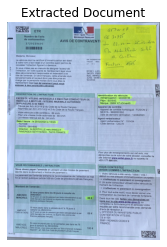

Extracted document saved at: ../data/processed/extracted_document.jpg


True

In [10]:
import os
import cv2
import matplotlib.pyplot as plt

# Specify the path to your input image
image_path = "../data/raw/WhatsApp Image 2024-03-15 at 12.16.07 (1).jpeg"
# Load the input image using OpenCV
image = cv2.imread(image_path, cv2.IMREAD_COLOR)[:, :, ::-1]
print(image.dtype)

# Assuming 'extract' and 'trained_model' are defined elsewhere
# Perform document extraction using the 'extract' function
document = extract(image_true=image, trained_model=trained_model)

# Display the extracted document without axes using matplotlib
plt.imshow(document / 255.0)
plt.title("Extracted Document")
plt.axis('off')  # Turn off axes (ticks and labels)
plt.show()

# Specify the output path for saving the extracted document
output_path = "../data/processed/extracted_document.jpg"

# Convert the document image from float64 to uint8 (if needed) and scale to [0, 255]
document_uint8 = (document).astype('uint8')
# Save the extracted document image to the specified output path
#cv2.imwrite(output_path, cv2.cvtColor(document_uint8, cv2.COLOR_RGB2BGR))

print(f"Extracted document saved at: {output_path}")
cv2.imwrite(output_path,document_uint8)